In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()
print(f"Spark Session Created. Version: {spark.version}")

Spark Session Created. Version: 3.5.0


In [0]:
#Defining the schema
schema = T.StructType([
    T.StructField("name", T.StringType(), True),
    T.StructField("CustomerID", T.StringType(), True),
    T.StructField("TenureMonths", T.IntegerType(), True),
    T.StructField("MonthlyCharges", T.DoubleType(), True),
    T.StructField("email", T.StringType(), True),
    T.StructField("PhoneNumber", T.StringType(), True),
    T.StructField("Churn", T.StringType(), True),
    T.StructField("TotalCharges", T.StringType(), True)
])

data_path = "/FileStore/tables/synthetic_churn_data.csv"

df = spark.read.csv(data_path, header=True, schema=schema)

print(f'Data loaded. Row Count: "{df.count()}"')
df.printSchema()
df.show(5)


Data loaded. Row Count: "10000000"
root
 |-- name: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- TenureMonths: integer (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- email: string (nullable = true)
 |-- PhoneNumber: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- TotalCharges: string (nullable = true)

+--------------+--------------+------------+--------------+--------------------+-------------------+-----+------------+
|          name|    CustomerID|TenureMonths|MonthlyCharges|               email|        PhoneNumber|Churn|TotalCharges|
+--------------+--------------+------------+--------------+--------------------+-------------------+-----+------------+
|   Megan Munoz|CUST_000000000|          65|         46.27|bdickerson@exampl...|   001-454-721-6528|    0|     3302.53|
|Matthew Fuller|CUST_000000001|           1|         77.51|matthewmccarthy@e...|+1-587-704-8741x057|    0|       78.52|
|  Maria Harris|CUST_00000000

In [0]:
#Handeling Missing Values
df = df.withColumn(
    "TotalCharges",
    F.expr("CASE WHEN TRIM(TotalCharges) = '' THEN NULL ELSE CAST(TotalCharges AS DOUBLE) END")
)

#Inputting 0 for missing data
df  = df.fillna({"TotalCharges": 0.0})

#Checking for other nulls
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----------+------------+--------------+-----+-----------+-----+------------+
|name|CustomerID|TenureMonths|MonthlyCharges|email|PhoneNumber|Churn|TotalCharges|
+----+----------+------------+--------------+-----+-----------+-----+------------+
|   0|         0|           0|             0|    0|          0|    0|           0|
+----+----------+------------+--------------+-----+-----------+-----+------------+



In [0]:
df = df.withColumn("Churn",
                   F.col("Churn").cast(T.IntegerType()))

df.printSchema()

root
 |-- name: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- TenureMonths: integer (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- email: string (nullable = true)
 |-- PhoneNumber: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- TotalCharges: double (nullable = false)



In [0]:
df = df.dropDuplicates(['CustomerID'])

In [0]:
df = df.withColumn("TenureYears", F.col("TenureMonths") / 12.0)
df = df.withColumn("ChargeRatio", F.when(F.col("TotalCharges") > 0, F.col("MonthlyCharges") / F.col("TotalCharges")).otherwise(0))

df = df.withColumn("TenureGroup", F.when(F.col("TenureMonths") <= 12, "0-1 Year")
                   .when((F.col("TenureMonths") > 12) & (F.col("TenureMonths") <= 36), "1-3 Years").otherwise(">3 Years"))

In [0]:
df.createOrReplaceTempView("churn_data")

#Example of sql query
query = """
SELECT
    CustomerID,
    TenureMonths,
    MonthlyCharges,
    TotalCharges,
    Churn,
    CASE
        WHEN TenureMonths <= 12 THEN 'Low_Tenure'
        WHEN TenureMonths > 12 AND TenureMonths <= 48 THEN 'Mid_Tenure'
        ELSE 'High_Tenure'
    END AS TenureCategory
FROM churn_data
WHERE MonthlyCharges > 0
"""

df_transformed = spark.sql(query)
df_transformed.show()

+--------------+------------+--------------+------------+-----+--------------+
|    CustomerID|TenureMonths|MonthlyCharges|TotalCharges|Churn|TenureCategory|
+--------------+------------+--------------+------------+-----+--------------+
|CUST_000000362|           8|        102.19|      737.63|    0|    Low_Tenure|
|CUST_000000478|          30|          66.3|     2025.29|    0|    Mid_Tenure|
|CUST_000000495|          32|         85.53|     3102.23|    0|    Mid_Tenure|
|CUST_000000596|          63|         91.06|     6557.88|    0|   High_Tenure|
|CUST_000000703|          19|         33.15|      655.77|    0|    Mid_Tenure|
|CUST_000000764|          63|         49.66|     2752.25|    0|   High_Tenure|
|CUST_000000835|          44|         47.78|     2215.28|    0|    Mid_Tenure|
|CUST_000000855|          44|         66.08|      2435.9|    0|    Mid_Tenure|
|CUST_000000914|          15|         87.45|     1301.48|    1|    Mid_Tenure|
|CUST_000001040|          68|        102.47|     606

In [0]:
df.select("TenureMonths", "MonthlyCharges", "TotalCharges").describe().show()

+-------+------------------+-----------------+------------------+
|summary|      TenureMonths|   MonthlyCharges|      TotalCharges|
+-------+------------------+-----------------+------------------+
|  count|          10000000|         10000000|          10000000|
|   mean|        35.0021692| 70.7935319840069|2454.3567972099772|
| stddev|19.914961043274303|28.91749439484723|1874.0643845251489|
|    min|                 1|             -0.0|               0.0|
|    max|                69|           226.94|          16322.62|
+-------+------------------+-----------------+------------------+



In [0]:
df.groupby("TenureGroup").count().orderBy(F.desc("count")).show()

+-----------+-------+
|TenureGroup|  count|
+-----------+-------+
|   >3 Years|4783782|
|  1-3 Years|3477352|
|   0-1 Year|1738866|
+-----------+-------+



In [0]:
df.groupby("Churn").count().show()

df.groupBy("TenureGroup").agg(F.mean("Churn").alias("ChurnRate")).orderBy("TenureGroup").show()

+-----+-------+
|Churn|  count|
+-----+-------+
|    1|1673697|
|    0|8326303|
+-----+-------+

+-----------+-------------------+
|TenureGroup|          ChurnRate|
+-----------+-------------------+
|   0-1 Year| 0.3010939313322591|
|  1-3 Years| 0.2116159077366916|
|   >3 Years|0.08659926392966903|
+-----------+-------------------+



In [0]:
for col in df.dtypes:
    print(col[0]+" , "+col[1])

name , string
CustomerID , string
TenureMonths , int
MonthlyCharges , double
email , string
PhoneNumber , string
Churn , int
TotalCharges , double
TenureYears , double
ChargeRatio , double
TenureGroup , string


In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numeric_cols = ["TenureMonths", "Churn", "TotalCharges", "TenureYears", "ChargeRatio"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="corr_feature")
df_vector = assembler.transform(df.select(numeric_cols)).select("corr_feature")

matrix = Correlation.corr(df_vector, "corr_feature").head()
print("Pearson Correlation Matrix:\n" + str(matrix[0]))

Pearson Correlation Matrix:
DenseMatrix([[ 1.        , -0.23841007,  0.74540726,  1.        , -0.52160114],
             [-0.23841007,  1.        , -0.06141085, -0.23841007,  0.13330736],
             [ 0.74540726, -0.06141085,  1.        ,  0.74540726, -0.38970482],
             [ 1.        , -0.23841007,  0.74540726,  1.        , -0.52160114],
             [-0.52160114,  0.13330736, -0.38970482, -0.52160114,  1.        ]])


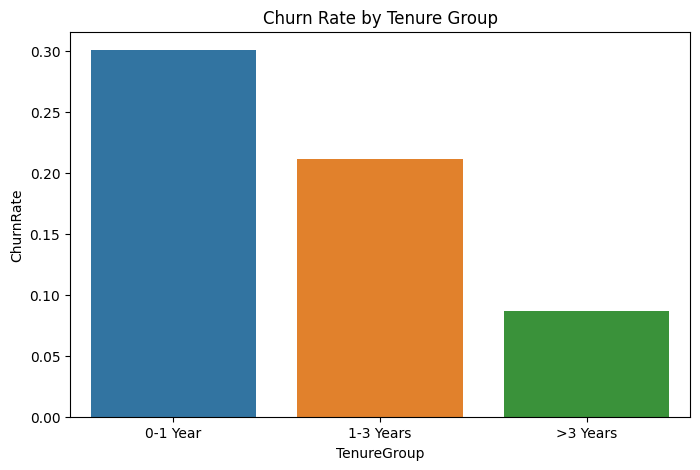

In [0]:
churn_by_TenureGroup = df.groupBy("TenureGroup").agg(F.mean("churn").alias("ChurnRate")).orderBy("TenureGroup").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x = "TenureGroup", y = "ChurnRate", data=churn_by_TenureGroup)
plt.title("Churn Rate by Tenure Group")
plt.show()

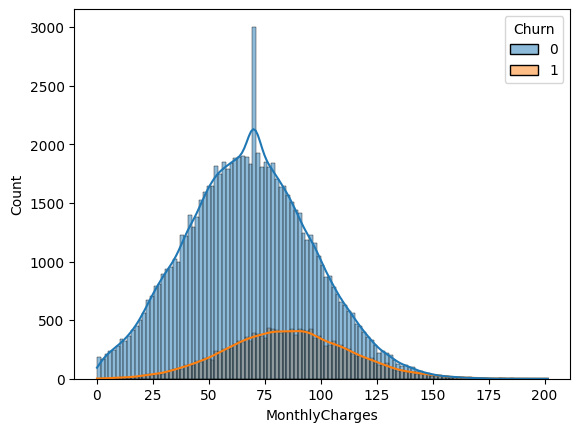

In [0]:
df_sample_pd = df.sample(withReplacement=False, fraction = 0.01, seed = 42).toPandas()

sns.histplot(data = df_sample_pd, x="MonthlyCharges", hue="Churn", kde=True)
plt.show()

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Identify categorical and numerical columns (excluding ID and original target string)
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, T.StringType) and f.name not in ['name', 'CustomerID', 'email', 'PhoneNumber']]


numerical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (T.IntegerType, T.DoubleType)) and f.name not in ['Churn']]


# Define stages for the pipeline
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_cols]
assembler_inputs = [col+"_vec" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

stages = indexers + encoders + [assembler]

# Create and fit the feature transformation pipeline
feature_pipeline = Pipeline(stages=stages)
feature_model = feature_pipeline.fit(df)
df_features = feature_model.transform(df)

# Select only features and the label
df_model_data = df_features.select("features", "Churn")
df_model_data.show(5, truncate=False)

# Split data
(train_data, test_data) = df_model_data.randomSplit([0.8, 0.2], seed=42)
print(f"Training data count: {train_data.count()}, Test data count: {test_data.count()}")

+-----------------------------------------------------------------------+-----+
|features                                                               |Churn|
+-----------------------------------------------------------------------+-----+
|[0.0,0.0,1.0,8.0,102.19,737.63,0.6666666666666666,0.13853829155538686] |0    |
|[0.0,1.0,0.0,30.0,66.3,2025.29,2.5,0.03273605261468728]                |0    |
|[0.0,1.0,0.0,32.0,85.53,3102.23,2.6666666666666665,0.02757048961553463]|0    |
|[1.0,0.0,0.0,63.0,91.06,6557.88,5.25,0.01388558497563237]              |0    |
|[0.0,1.0,0.0,19.0,33.15,655.77,1.5833333333333333,0.05055126035042774] |0    |
+-----------------------------------------------------------------------+-----+
only showing top 5 rows

Training data count: 7999765, Test data count: 2000235


In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="Churn")

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)
predictions.select("Churn", "prediction", "probability").show(10, truncate=False)

evaluator_auc = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction")

auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f'Area under ROC (AUC): "{auc:.4f}"')
print(f'accuracy: "{accuracy:.4f}"')
print(f'precision: "{precision:.4f}"')
print(f'Recall: "{recall:.4f}"')
print(f'f1 Score: "{f1:.4f}"')

+-----+----------+-----------------------------------------+
|Churn|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
|0    |0.0       |[0.9428942490682273,0.057105750931772725]|
+-----+----------+-----------------------------------------+
only showing top 10 rows

Area under ROC (AUC): "0.7535"
accuracy: "0.8317"
precision: "0.7780"
Recall: "0.8317"
f1 Score: "0.7694"


In [0]:
rf = RandomForestClassifier(featuresCol="features", labelCol="Churn")
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

predictions.select("Churn", "prediction", "probability").show(10, truncate=False)

evaluator_auc = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction")

auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f'Area under ROC (AUC): "{auc:.4f}"')
print(f'accuracy: "{accuracy:.4f}"')
print(f'precision: "{precision:.4f}"')
print(f'Recall: "{recall:.4f}"')
print(f'f1 Score: "{f1:.4f}"')

+-----+----------+---------------------------------------+
|Churn|prediction|probability                            |
+-----+----------+---------------------------------------+
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
|0    |0.0       |[0.8417779238162548,0.1582220761837451]|
+-----+----------+---------------------------------------+
only showing top 10 rows

Area under ROC (AUC): "0.6917"
accuracy: "0.8323"
precision: "0.6927"
Recall: "0.8323"
f1 Score: "0.7561"


In [0]:
# Assuming 'predictions_df' is your DataFrame with the 'probability' column
distinct_probabilities_count = predictions.select("probability").distinct().count()
print(f"Number of distinct probabilities in the test set: {distinct_probabilities_count}")

# You can also look at the distribution
predictions.groupBy("probability").count().orderBy("count", ascending=False).show(truncate=False)

Number of distinct probabilities in the test set: 22
+----------------------------------------+------+
|probability                             |count |
+----------------------------------------+------+
|[0.8417779238162548,0.1582220761837451] |956827|
|[0.8341672310050352,0.16583276899496482]|290314|
|[0.8218423353782406,0.17815766462175944]|179000|
|[0.830082159270615,0.16991784072938496] |173890|
|[0.8114065841410906,0.1885934158589094] |107824|
|[0.8160904291223178,0.18390957087768217]|60075 |
|[0.8380128032227528,0.16198719677724718]|58406 |
|[0.8317170655500566,0.16828293444994324]|39282 |
|[0.7943218620460821,0.20567813795391793]|21625 |
|[0.7928471201909967,0.20715287980900327]|21109 |
|[0.8289084782158878,0.1710915217841122] |18487 |
|[0.8093377481919144,0.1906622518080856] |17864 |
|[0.8188990164564867,0.1811009835435132] |13464 |
|[0.8053152084231925,0.19468479157680738]|10729 |
|[0.8124858049880587,0.18751419501194136]|7118  |
|[0.7852541104812034,0.21474588951879664]|6148 

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Identify categorical and numerical columns (excluding ID and original target string)
categorical_cols = [f.name for f in df_transformed.schema.fields if isinstance(f.dataType, T.StringType) and f.name not in ['name', 'CustomerID', 'email', 'PhoneNumber']]


numerical_cols = [f.name for f in df_transformed.schema.fields if isinstance(f.dataType, (T.IntegerType, T.DoubleType)) and f.name not in ['Churn']]


# Define stages for the pipeline
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_cols]
assembler_inputs = [col+"_vec" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

stages = indexers + encoders + [assembler]

# Create and fit the feature transformation pipeline
feature_pipeline = Pipeline(stages=stages)
feature_model = feature_pipeline.fit(df_transformed)
df_features = feature_model.transform(df_transformed)

# Select only features and the label
df_model_data = df_features.select("features", "Churn")
df_model_data.show(5, truncate=False)

# Split data
(train_data, test_data) = df_model_data.randomSplit([0.8, 0.2], seed=42)
print(f"Training data count: {train_data.count()}, Test data count: {test_data.count()}")

+--------------------------------+-----+
|features                        |Churn|
+--------------------------------+-----+
|[0.0,0.0,1.0,8.0,102.19,737.63] |0    |
|[1.0,0.0,0.0,30.0,66.3,2025.29] |0    |
|[1.0,0.0,0.0,32.0,85.53,3102.23]|0    |
|[0.0,1.0,0.0,63.0,91.06,6557.88]|0    |
|[1.0,0.0,0.0,19.0,33.15,655.77] |0    |
+--------------------------------+-----+
only showing top 5 rows

Training data count: 7999709, Test data count: 2000215


In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="Churn")

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)
predictions.select("Churn", "prediction", "probability").show(10, truncate=False)

evaluator_auc = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction")

auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f'Area under ROC (AUC): "{auc:.4f}"')
print(f'accuracy: "{accuracy:.4f}"')
print(f'precision: "{precision:.4f}"')
print(f'Recall: "{recall:.4f}"')
print(f'f1 Score: "{f1:.4f}"')

+-----+----------+----------------------------------------+
|Churn|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.8530838575680261,0.14691614243197393]|
|0    |0.0       |[0.8527979990164746,0.14720200098352543]|
|0    |0.0       |[0.8522948211725874,0.14770517882741263]|
|0    |0.0       |[0.8511840492971444,0.14881595070285558]|
|0    |0.0       |[0.8505903027772054,0.14940969722279462]|
|0    |0.0       |[0.8499868510338898,0.15001314896611018]|
|0    |0.0       |[0.8495503406103462,0.15044965938965382]|
|0    |0.0       |[0.8489364259957211,0.15106357400427894]|
|0    |0.0       |[0.8482467833384124,0.1517532166615876] |
|0    |0.0       |[0.848203405633607,0.15179659436639303] |
+-----+----------+----------------------------------------+
only showing top 10 rows

Area under ROC (AUC): "0.7539"
accuracy: "0.8317"
precision: "0.7777"
Recall: "0.8317"
f1 Score: "0.7691"


In [0]:
rf = RandomForestClassifier(featuresCol="features", labelCol="Churn")
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

predictions.select("Churn", "prediction", "probability").show(10, truncate=False)

evaluator_auc = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction")

auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f'Area under ROC (AUC): "{auc:.4f}"')
print(f'accuracy: "{accuracy:.4f}"')
print(f'precision: "{precision:.4f}"')
print(f'Recall: "{recall:.4f}"')
print(f'f1 Score: "{f1:.4f}"')

+-----+----------+----------------------------------------+
|Churn|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
|0    |0.0       |[0.8302349276106726,0.16976507238932742]|
+-----+----------+----------------------------------------+
only showing top 10 rows

Area under ROC (AUC): "0.7140"
accuracy: "0.8323"
precision: "0.6928"
Recall: "0.8323"
f1 Score: "0.7562"


In [0]:
# Assuming 'predictions_df' is your DataFrame with the 'probability' column
distinct_probabilities_count = predictions.select("probability").distinct().count()
print(f"Number of distinct probabilities in the test set: {distinct_probabilities_count}")

# You can also look at the distribution
predictions.groupBy("probability").count().orderBy("count", ascending=False).show(truncate=False)

Number of distinct probabilities in the test set: 30
+----------------------------------------+------+
|probability                             |count |
+----------------------------------------+------+
|[0.8436593974879848,0.15634060251201518]|634736|
|[0.8376119902482507,0.16238800975174922]|414913|
|[0.837351309333479,0.16264869066652105] |343073|
|[0.8176640759005744,0.18233592409942567]|176967|
|[0.8302349276106726,0.16976507238932742]|164183|
|[0.8149120653985114,0.1850879346014887] |41081 |
|[0.7983217888826367,0.20167821111736325]|38290 |
|[0.7958027598934232,0.20419724010657667]|33731 |
|[0.8239721640550802,0.1760278359449198] |23694 |
|[0.8234620490468538,0.1765379509531461] |15759 |
|[0.7824924794035644,0.21750752059643572]|15639 |
|[0.7850647282845727,0.2149352717154273] |14578 |
|[0.8109573320599084,0.18904266794009164]|13173 |
|[0.7931596787836923,0.2068403212163077] |10570 |
|[0.7977760579221409,0.20222394207785904]|10502 |
|[0.8282616295819549,0.17173837041804507]|9929 